# Lab 4: Data Imputation using an Autoencoder


In this lab, you will build and train an autoencoder to impute (or "fill in") missing data.

We will be using the
Adult Data Set provided by the UCI Machine Learning Repository [1], available
at https://archive.ics.uci.edu/ml/datasets/adult.
The data set contains census record files of adults, including their
age, martial status, the type of work they do, and other features.

Normally, people use this data set to build a supervised classification
model to classify whether a person is a high income earner.
We will not use the dataset for this original intended purpose.

Instead, we will perform the task of imputing (or "filling in") missing values in the dataset. For example,
we may be missing one person's martial status, and another person's age, and
a third person's level of education. Our model will predict the missing features
based on the information that we do have about each person.

We will use a variation of a denoising autoencoder to solve this data imputation
problem. Our autoencoder will be trained using inputs that have one categorical feature artificially
removed, and the goal of the autoencoder is to correctly reconstruct all features,
including the one removed from the input.

In the process, you are expected to learn to:

1. Clean and process continuous and categorical data for machine learning.
2. Implement an autoencoder that takes continuous and categorical (one-hot) inputs.
3. Tune the hyperparameters of an autoencoder.
4. Use baseline models to help interpret model performance.

[1] Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.


## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://drive.google.com/file/d/1Gox4p9EyjNnjbSPYYz0Vdm1e9tdIEkn7/view?usp=sharing

In [1]:
import csv
import numpy as np
import random
import torch
import torch.utils.data

## Part 0

We will be using a package called `pandas` for this assignment.

If you are using Colab, `pandas` should already be available.
If you are using your own computer,
installation instructions for `pandas` are available here:
https://pandas.pydata.org/pandas-docs/stable/install.html

In [2]:
import pandas as pd

# Part 1. Data Cleaning [15 pt]

The adult.data file is available at `https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data`

The function `pd.read_csv` loads the adult.data file into a pandas dataframe.
You can read about the pandas documentation for `pd.read_csv` at
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [3]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=header,
    index_col=False)

/tmp/ipython-input-3-1831985018.py:3: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv(


In [4]:
df.shape # there are 32561 rows (records) in the data frame, and 14 columns (features)

(32561, 14)

### Part (a) Continuous Features [3 pt]

For each of the columns `["age", "yredu", "capgain", "caploss", "workhr"]`, report the minimum, maximum, and average value across the dataset.

Then, normalize each of the features `["age", "yredu", "capgain", "caploss", "workhr"]`
so that their values are always between 0 and 1.
Make sure that you are actually modifying the dataframe `df`.

Like numpy arrays and torch tensors,
pandas data frames can be sliced. For example, we can
display the first 3 rows of the data frame (3 records) below.

In [5]:
df[:3] # show first 3 records

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States


Alternatively, we can slice based on column names,
for example `df["race"]`, `df["hr"]`, or even index multiple columns
like below.

In [6]:
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
subdf[:3] # show the first 3 records

,age,yredu,capgain,caploss,workhr
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40


Numpy works nicely with pandas, like below:

In [7]:
np.sum(subdf["caploss"])

np.int64(2842700)

Just like numpy arrays, you can modify
entire columns of data rather than one scalar element at a time.
For example, the code  

`df["age"] = df["age"] + 1`

would increment everyone's age by 1.

In [8]:
df[:3] # show the first 3 records

# age
age_max = df["age"].max()
age_min = df["age"].min()
age_avg = df["age"].mean()
print("Age")
print("Max: ", age_max)
print("Min: ", age_min)
print("Avg: ", age_avg)

# yredu
yredu_max = df["yredu"].max()
yredu_min = df["yredu"].min()
yredu_avg = df["yredu"].mean()
print("Yredu")
print("Max: ", yredu_max)
print("Min: ", yredu_min)
print("Avg: ", yredu_avg)

# capgain
capgain_max = df["capgain"].max()
capgain_min = df["capgain"].min()
capgain_avg = df["capgain"].mean()
print("Capgain")
print("Max: ", capgain_max)
print("Min: ", capgain_min)
print("Avg: ", capgain_avg)

# caploss
caploss_max = df["caploss"].max()
caploss_min = df["caploss"].min()
caploss_avg = df["caploss"].mean()
print("Caploss")
print("Max: ", caploss_max)
print("Min: ", caploss_min)
print("Avg: ", caploss_avg)

# workhr
workhr_max = df["workhr"].max()
workhr_min = df["workhr"].min()
workhr_avg = df["workhr"].mean()
print("Workhr")
print("Max: ", workhr_max)
print("Min: ", workhr_min)
print("Avg: ", workhr_avg)

# normalize
df["age"] = (df["age"] - age_min) / (age_max - age_min)
df["yredu"] = (df["yredu"] - yredu_min) / (yredu_max - yredu_min)
df["capgain"] = (df["capgain"] - capgain_min) / (capgain_max - capgain_min)
df["caploss"] = (df["caploss"] - caploss_min) / (caploss_max - caploss_min)
df["workhr"] = (df["workhr"] - workhr_min) / (workhr_max - workhr_min)

Age
Max:  90
Min:  17
Avg:  38.58164675532078
Yredu
Max:  16
Min:  1
Avg:  10.0806793403151
Capgain
Max:  99999
Min:  0
Avg:  1077.6488437087312
Caploss
Max:  4356
Min:  0
Avg:  87.303829734959
Workhr
Max:  99
Min:  1
Avg:  40.437455852092995


### Part (b) Categorical Features [1 pt]

What percentage of people in our data set are male? Note that the data labels all have an unfortunate space in the beginning, e.g. " Male" instead of "Male".

What percentage of people in our data set are female?

In [9]:
# hint: you can do something like this in pandas
sum(df["sex"] == " Male")
print("Percentage Males: " + str((sum(df["sex"] == " Male") / len(df)) * 100) + "%")
print("Percentage Females: " + str((sum(df["sex"] == " Female") / len(df)) * 100) + "%")

Percentage Males: 66.92054912318419%
Percentage Females: 33.07945087681583%


### Part (c) [2 pt]

Before proceeding, we will modify our data frame in a couple more ways:

1. We will restrict ourselves to using a subset of the features (to simplify our autoencoder)
2. We will remove any records (rows) already containing missing values, and store them in a second dataframe. We will only use records without missing values to train our autoencoder.

Both of these steps are done for you, below.

How many records contained missing features? What percentage of records were removed?

In [10]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
features = contcols + catcols
df = df[features]

In [11]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_with_missing = df[missing]
df_not_missing = df[~missing]

In [12]:
print("Records with Missing Features: " + str(len(df_with_missing)))
print("Percentage of Records Removed: " + str((len(df_with_missing) / len(df["age"])) * 100) + "%")

Records with Missing Features: 1843
Percentage of Records Removed: 5.660145572924664%


### Part (d) One-Hot Encoding [1 pt]

What are all the possible values of the feature "work" in `df_not_missing`? You may find the Python function `set` useful.

In [13]:
set(df_not_missing["work"])

{' Federal-gov',
 ' Local-gov',
 ' Private',
 ' Self-emp-inc',
 ' Self-emp-not-inc',
 ' State-gov',
 ' Without-pay'}

We will be using a one-hot encoding to represent each of the categorical variables.
Our autoencoder will be trained using these one-hot encodings.

We will use the pandas function `get_dummies` to produce one-hot encodings
for all of the categorical variables in `df_not_missing`.

In [14]:
data = pd.get_dummies(df_not_missing)

In [15]:
data[:3]

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,...,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.301370,0.800000,0.02174,0.0,0.397959,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
1,0.452055,0.800000,0.00000,0.0,0.122449,False,False,False,False,True,...,False,False,True,False,False,False,False,False,False,True
2,0.287671,0.533333,0.00000,0.0,0.397959,False,False,True,False,False,...,False,False,False,True,False,False,False,False,False,True


### Part (e) One-Hot Encoding [2 pt]

The dataframe `data` contains the cleaned and normalized data that we will use to train our denoising autoencoder.

How many **columns** (features) are in the dataframe `data`?

Briefly explain where that number come from.

In [16]:
print("Number of Columns: " + str(len(data.columns)))
# Each One-Hot Encoding Created New Columns for Each Category, Creating Multiple Binary Columns
# Check if the Number of Binary Conditions is 57
# Added 5 which is the pre existing categories
num_columns = 5 + len(set(df_not_missing["work"])) + len(set(df_not_missing["marriage"])) + len(set(df_not_missing["occupation"])) + len(set(df_not_missing["edu"])) + len(set(df_not_missing["relationship"])) + len(set(df_not_missing["sex"]))
print("Number of Binary Columns: " + str(num_columns))

Number of Columns: 57
Number of Binary Columns: 57


### Part (f) One-Hot Conversion [3 pt]

We will convert the pandas data frame `data` into numpy, so that
it can be further converted into a PyTorch tensor.
However, in doing so, we lose the column label information that
a panda data frame automatically stores.

Complete the function `get_categorical_value` that will return
the named value of a feature given a one-hot embedding.
You may find the global variables `cat_index` and `cat_values`
useful. (Display them and figure out what they are first.)

We will need this function in the next part of the lab
to interpret our autoencoder outputs. So, the input
to our function `get_categorical_values` might not
actually be "one-hot" -- the input may instead
contain real-valued predictions from our neural network.

In [17]:
datanp = data.values.astype(np.float32)

In [18]:
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header
        feature, value = header.split()
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i
            cat_values[feature] = [value]
        else:
            cat_values[feature].append(value)

def get_onehot(record, feature):
    """
    Return the portion of `record` that is the one-hot encoding
    of `feature`. For example, since the feature "work" is stored
    in the indices [5:12] in each record, calling `get_range(record, "work")`
    is equivalent to accessing `record[5:12]`.

    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.

    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`

    Examples:

    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """
    # <----- TODO: WRITE YOUR CODE HERE ----->
    index = np.argmax(onehot)
    return cat_values[feature][index]
    # You may find the variables `cat_index` and `cat_values`
    # (created above) useful.

In [19]:
# more useful code, used during training, that depends on the function
# you write above

def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }

### Part (g) Train/Test Split [3 pt]

Randomly split the data into approximately 70% training, 15% validation and 15% test.

Report the number of items in your training, validation, and test set.

In [20]:
# set the numpy seed for reproducibility
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html
np.random.seed(50)

# todo
train_size = int(0.7 * len(datanp))
valid_size = int(0.15 * len(datanp))
test_size = len(datanp) - train_size - valid_size

train_data, valid_data, test_data = torch.utils.data.random_split(datanp, [train_size, valid_size, test_size])

print("Training Size: " + str(len(train_data)))
print("Validation Size: " + str(len(valid_data)))
print("Test Size: " + str(len(test_data)))

Training Size: 21502
Validation Size: 4607
Test Size: 4609


## Part 2. Model Setup [5 pt]

### Part (a) [4 pt]

Design a fully-connected autoencoder by modifying the `encoder` and `decoder`
below.

The input to this autoencoder will be the features of the `data`, with
one categorical feature recorded as "missing". The output of the autoencoder
should be the reconstruction of the same features, but with the missing
value filled in.

**Note**: Do not reduce the dimensionality of the input too much!
The output of your embedding is expected to contain information
about ~11 features.

In [26]:
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(57, 40),
            nn.ReLU(),
            nn.Linear(40, 20),
            nn.ReLU(),
            nn.Linear(20, 11), # Bottleneck to about 11 features
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(11, 20),
            nn.ReLU(),
            nn.Linear(20, 40),
            nn.ReLU(),
            nn.Linear(40, 57),
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Part (b) [1 pt]

Explain why there is a sigmoid activation in the last step of the decoder.

(**Note**: the values inside the data frame `data` and the training code in Part 3 might be helpful.)

**The information the autoencoder will predict is the missing categorical feature that is seperated into multiple binary columns.  Therefore, it must have a normalized output of between [0,1], which is achieved by the sigmoid activation.**

## Part 3. Training [18]

### Part (a) [6 pt]

We will train our autoencoder in the following way:

- In each iteration, we will hide one of the categorical features using the `zero_out_random_features` function
- We will pass the data with one missing feature through the autoencoder, and obtain a reconstruction
- We will check how close the reconstruction is compared to the original data -- including the value of the missing feature

Complete the code to train the autoencoder, and plot the training and validation loss every few iterations.
You may also want to plot training and validation "accuracy" every few iterations, as we will define in
part (b). You may also want to checkpoint your model every few iterations or epochs.

Use `nn.MSELoss()` as your loss function. (Side note: you might recognize that this loss function is not
ideal for this problem, but we will use it anyway.)

In [29]:
def zero_out_feature(records, feature):
    """ Set the feature missing in records, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    records[:, start_index:stop_index] = 0
    return records

def zero_out_random_feature(records):
    """ Set one random feature missing in records, by setting the
    appropriate columns of records to 0
    """
    return zero_out_feature(records, random.choice(catcols))

def get_loss(model, data_loader, criterion):
    model.eval()
    total_loss = 0
    index = 0
    for data in data_loader:
        datam = zero_out_random_feature(data.clone())
        recon = model(datam)
        loss = criterion(recon, data)
        total_loss += loss.item()
        index += 1
    return total_loss / index

def train(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-4):
    """ Training loop. You should update this."""
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_acc = np.zeros(num_epochs)
    valid_acc = np.zeros(num_epochs)

    train_loss = np.zeros(num_epochs)
    valid_loss = np.zeros(num_epochs)

    for epoch in range(num_epochs):
        index = 0
        total_loss = 0
        for data in train_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            loss = criterion(recon, data)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()
            index += 1

        train_acc[epoch] = get_accuracy(model, train_loader)
        valid_acc[epoch] = get_accuracy(model, valid_loader)
        train_loss[epoch] = total_loss / (index+1)
        valid_loss[epoch] = get_loss(model, valid_loader, criterion)

        print("epoch: ", epoch+1)
        print("train loss: ", train_loss[epoch])
        print("train acc: ", train_acc[epoch])
        print("valid loss: ", valid_loss[epoch])
        print("valid acc: ", valid_acc[epoch])

    epochs = np.arange(1, num_epochs+1)
    return epochs, train_loss, valid_loss, train_acc, valid_acc

### Part (b) [3 pt]

While plotting training and validation loss is valuable, loss values are harder to compare
than accuracy percentages. It would be nice to have a measure of "accuracy" in this problem.

Since we will only be imputing missing categorical values, we will define an accuracy measure.
For each record and for each categorical feature, we determine whether
the model can predict the categorical feature given all the other features of the record.

A function `get_accuracy` is written for you. It is up to you to figure out how to
use the function. **You don't need to submit anything in this part.**
To earn the marks, correctly plot the training and validation accuracy every few
iterations as part of your training curve.

In [23]:
def get_accuracy(model, data_loader):
    """Return the "accuracy" of the autoencoder model across a data set.
    That is, for each record and for each categorical feature,
    we determine whether the model can successfully predict the value
    of the categorical feature given all the other features of the
    record. The returned "accuracy" measure is the percentage of times
    that our model is successful.

    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             Depending on your variable naming this code might require
             modification.)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """
    total = 0
    acc = 0
    for col in catcols:
        for item in data_loader: # minibatches
            inp = item.detach().numpy()
            out = model(zero_out_feature(item.clone(), col)).detach().numpy()
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
    return acc / total

### Part (c) [4 pt]

Run your updated training code, using reasonable initial hyperparameters.

Include your training curve in your submission.

epoch:  1
train loss:  0.07352530944090542
train acc:  0.571218181254457
valid loss:  0.05242440583080881
valid acc:  0.5692424571304536
epoch:  2
train loss:  0.04868647280698545
train acc:  0.5840154404241465
valid loss:  0.04333733239521583
valid acc:  0.5804572751609869
epoch:  3
train loss:  0.04056448843136408
train acc:  0.6059591355842867
valid loss:  0.03803753735135413
valid acc:  0.6046595760075247
epoch:  4
train loss:  0.036195834439917626
train acc:  0.6074628716708523
valid loss:  0.03512508675663008
valid acc:  0.6045148686780986
epoch:  5
train loss:  0.03356430189958033
train acc:  0.6156559079775524
valid loss:  0.03267041719259901
valid acc:  0.6126908327906808
epoch:  6
train loss:  0.03180509768315711
train acc:  0.6101990512510465
valid loss:  0.030771473810697596
valid acc:  0.6061066493017871
epoch:  7
train loss:  0.03012779449150077
train acc:  0.6085557932595418
valid loss:  0.02978180899905662
valid acc:  0.6058895883076478
epoch:  8
train loss:  0.02853204

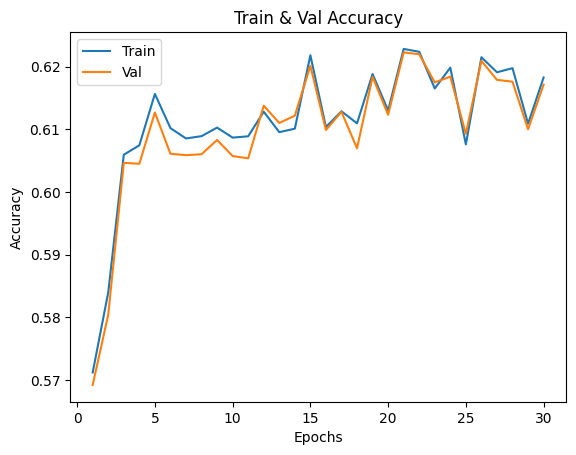

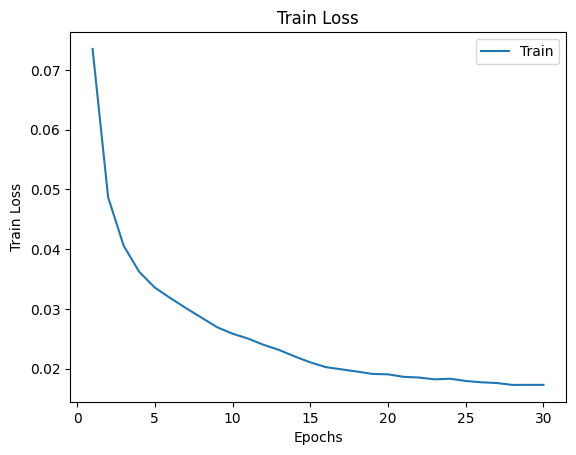

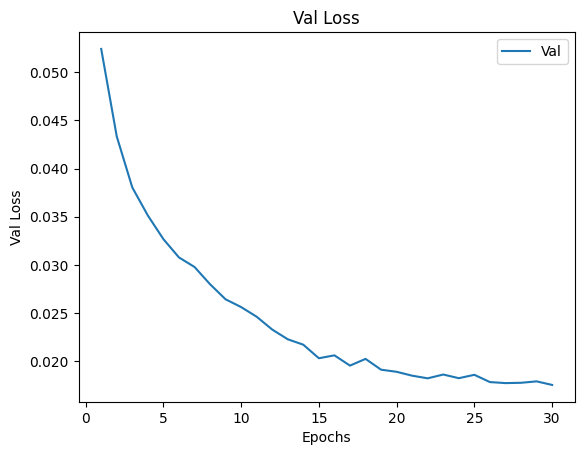

In [31]:
import matplotlib.pyplot as plt

# Initialize Hyperparameters
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size)
val_loader = torch.utils.data.DataLoader(valid_data, batch_size = batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size)

auto_encoder_0 = AutoEncoder()
epochs, train_loss, val_loss, train_acc, val_acc = train(auto_encoder_0, train_loader, val_loader, num_epochs = 30, learning_rate = 0.001)

plt.title("Train & Val Accuracy")
plt.plot(epochs, train_acc, label="Train")
plt.plot(epochs, val_acc, label="Val")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

plt.title("Train Loss")
plt.plot(epochs, train_loss, label="Train")
plt.xlabel("Epochs")
plt.ylabel("Train Loss")
plt.legend(loc='best')
plt.show()

plt.title("Val Loss")
plt.plot(epochs, val_loss, label="Val")
plt.xlabel("Epochs")
plt.ylabel("Val Loss")
plt.legend(loc='best')
plt.show()

### Part (d) [5 pt]

Tune your hyperparameters, training at least 4 different models (4 sets of hyperparameters).

Do not include all your training curves. Instead, explain what hyperparameters
you tried, what their effect was, and what your thought process was as you
chose the next set of hyperparameters to try.

**First Set: Batch Size = 32, Epoch = 30, Learning Rate = 0.001.  Training and Validation accuracy are relatively the same, at a max of about 62%.  Both training and validation loss decrease plateaued to about 0.17.  Since overfitting has not been observed, the number of epochs will be increased to 50 to observe the effects of more training iterations.**

**Second Set: Batch Size = 32, Epoch = 50, Learning Rate = 0.001.  Similar to the first set, training and validation accuracy are relatively the same, at a max of about 63%.  The loss plateaued at around 0.16 for both training and validation.  Since overfitting is still not observed, the number of epochs will be increased to 100.  In addition, a smaller batch size of 16 will be used to introduce more noise.  This can help the model to escape the local minima.**

**Third Set: Batch Size = 16, Epoch = 100, Learning Rate = 0.001.  Slight improvement with the loss to around 0.12; however, it still plateaus and decreases slowly.  Accuracy increased slightly to about 65% for validation and 66% for training.  No signs of overfitting is present.  For the fourth and final set, learning rate will be increased to 0.005 to speed up the convergence as the model is training very slowly.**

**Fourth Set: Batch Size = 16, Epoch = 100, Learning Rate = 0.005.  Loss plateaued at around 0.17, which is higher than before; however, both training and validation accuracy increased to 68% and plateaued at around 60th epoch.  This is the set of hyperparameters with the best accuracy and will be used as the final model.**

epoch:  1
train loss:  0.051781181117249685
train acc:  0.5892552630763029
valid loss:  0.043564544085206255
valid acc:  0.5843281962231387
epoch:  2
train loss:  0.039637855829525614
train acc:  0.6120283384491365
valid loss:  0.03637920342023588
valid acc:  0.6098690398668692
epoch:  3
train loss:  0.03379495220335
train acc:  0.6028664000248039
valid loss:  0.033756378759992205
valid acc:  0.597749801027422
epoch:  4
train loss:  0.031568244457604935
train acc:  0.6122763773912504
valid loss:  0.030697449589044683
valid acc:  0.6076622530931192
epoch:  5
train loss:  0.02870442156357947
train acc:  0.6135010696679378
valid loss:  0.026782646325753175
valid acc:  0.612184357137689
epoch:  6
train loss:  0.02634089242729279
train acc:  0.6202058723219546
valid loss:  0.02552255773722815
valid acc:  0.6185876564648
epoch:  7
train loss:  0.025317491712844947
train acc:  0.6115090069140855
valid loss:  0.025319586630858894
valid acc:  0.6105563996816439
epoch:  8
train loss:  0.02333765

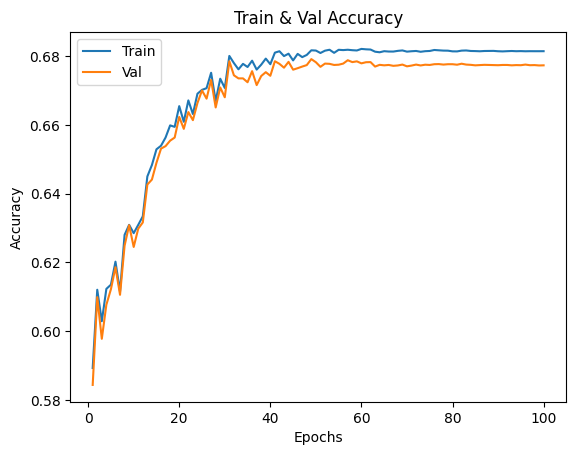

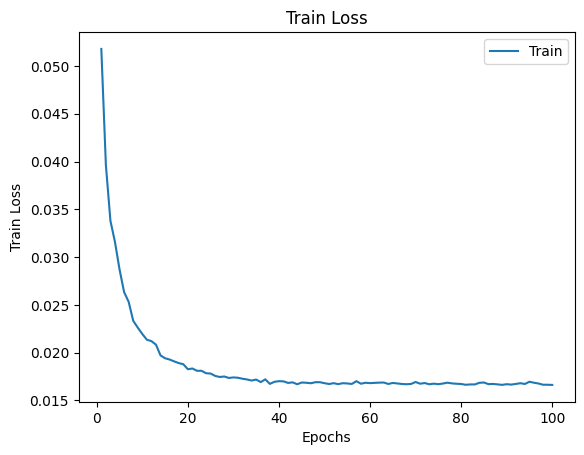

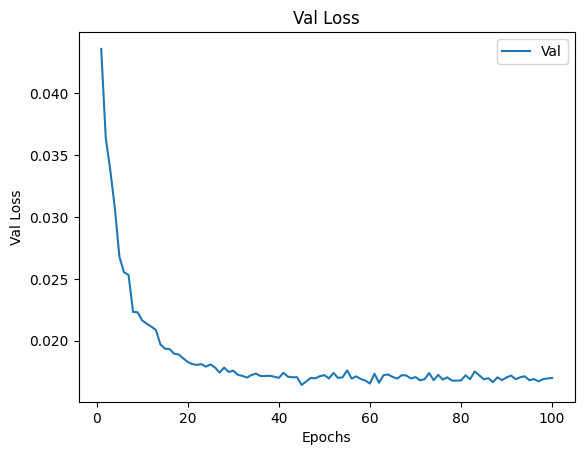

In [40]:
# Fourth Set Model (Used as Best/Final Model)
auto_encoder_3 = AutoEncoder()
batch_size = 16
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size)
val_loader = torch.utils.data.DataLoader(valid_data, batch_size = batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size)

epochs, train_loss, val_loss, train_acc, val_acc = train(auto_encoder_3, train_loader, val_loader, num_epochs = 100, learning_rate = 0.005)

plt.title("Train & Val Accuracy")
plt.plot(epochs, train_acc, label="Train")
plt.plot(epochs, val_acc, label="Val")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

plt.title("Train Loss")
plt.plot(epochs, train_loss, label="Train")
plt.xlabel("Epochs")
plt.ylabel("Train Loss")
plt.legend(loc='best')
plt.show()

plt.title("Val Loss")
plt.plot(epochs, val_loss, label="Val")
plt.xlabel("Epochs")
plt.ylabel("Val Loss")
plt.legend(loc='best')
plt.show()

## Part 4. Testing [12 pt]

### Part (a) [2 pt]

Compute and report the test accuracy.

In [42]:
print(get_accuracy(auto_encoder_3, test_loader))

0.677189556664497


**The test accuracy of the autoencoder is 68%**

### Part (b) [4 pt]

Based on the test accuracy alone, it is difficult to assess whether our model
is actually performing well. We don't know whether a high accuracy is due to
the simplicity of the problem, or if a poor accuracy is a result of the inherent
difficulty of the problem.

It is therefore very important to be able to compare our model to at least one
alternative. In particular, we consider a simple **baseline**
model that is not very computationally expensive. Our neural network
should at least outperform this baseline model. If our network is not much
better than the baseline, then it is not doing well.

For our data imputation problem, consider the following baseline model:
to predict a missing feature, the baseline model will look at the **most common value** of the feature in the training set.

For example, if the feature "marriage" is missing, then this model's prediction will be the most common value for "marriage" in the training set, which happens to be "Married-civ-spouse".

What would be the test accuracy of this baseline model?


In [75]:
# Extract the most common value of the feature in the training set
most_common_id = {}

train_indices = train_data.indices

train_df = df.iloc[train_indices]

for col in catcols:
    most_common_value = train_df[col].value_counts().idxmax().strip()
    most_common_id[col] = cat_values[col].index(most_common_value)

In [76]:
def baseline_model(vec):
    vec = vec.clone() # Leave the Original Unchanged
    for col in catcols:
        vec[:, cat_index[col]:cat_index[col]+len(cat_values[col])] = 0
        vec[:, cat_index[col]+most_common_id[col]] = 1
    return vec

In [77]:
print(get_accuracy(baseline_model, test_loader))

0.4597888189773631


**The test accuracy of the baseline model is 46%.**

### Part (c) [1 pt]

How does your test accuracy from part (a) compared to your basline test accuracy in part (b)?

**The test accuracy of the autoencoder is 68%, which is significantly better than the 46% test accuracy of the baseline model.**

### Part (d) [1 pt]

Look at the first item in your test data.
Do you think it is reasonable for a human
to be able to guess this person's education level
based on their other features? Explain.

In [78]:
for col in catcols:
    print(col + ": " + get_feature(test_data[0], col))

work: State-gov
marriage: Married-civ-spouse
occupation: Transport-moving
edu: Some-college
relationship: Husband
sex: Male


**In this case, yes.  Since this person's occupation is in transport-moving, which is a job that requires practical skills.  A human would predict some practical college where this person would have learned their occupation skills.**

### Part (e) [2 pt]

What is your model's prediction of this person's education
level, given their other features?


In [79]:
print(get_feature(auto_encoder_3(torch.tensor(test_data[0], dtype=torch.float32)).detach(), "edu"))

Some-college


**The model's prediction of this person's education level is some-college.**

### Part (f) [2 pt]

What is the baseline model's prediction
of this person's education level?

In [80]:
print(get_feature(baseline_model(torch.tensor(test_data[0], dtype=torch.float32).unsqueeze(0)).detach()[0], "edu"))

HS-grad


**The baseline model's prediction of this person's education level is high school graduate.  This is because high school degree is the most common education level in the education category of the training set.**